In [1]:
import tensorflow as tf
#from matplotlib import pyplot
import matplotlib.pyplot as plt
import random
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow import keras 
from random import randint

2024-05-13 20:48:33.383507: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 20:48:33.386173: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 20:48:33.428829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 20:48:34.198194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mnist_dataset = tf.keras.datasets.fashion_mnist.load_data()
 
(x_train, y_train), (x_test, y_test) = mnist_dataset
 
print(x_train.shape)
print(y_train.shape)
 
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
# Scaling 
# To make all data in same range
x_train = x_train / 255.0

x_test = x_test / 255.0

#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


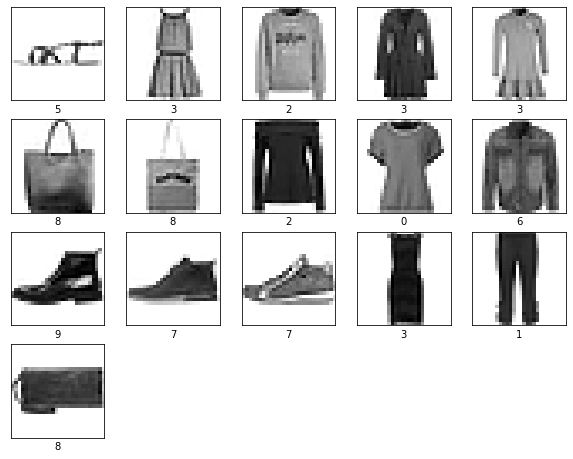

In [4]:
# Plotting 16 random images
plt.figure(figsize=(10,10))
for i in range(16):
    value = randint(0, 60000)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[value], cmap=plt.cm.binary)
    plt.xlabel(y_train[value])
plt.show()


In [5]:
# Plotting first 25 images
#plt.figure(figsize=(10,10))
#for i in range(25):
#    plt.subplot(5,5,i+1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.grid(False)
#    plt.imshow(x_train[i], cmap=plt.cm.binary)
#    plt.xlabel(class_names[y_train[i]])
#plt.show()


In [6]:
# Hyper börja
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [7]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
)


Reloading Tuner from ./untitled_project/tuner0.json


In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [9]:
tuner.search(x_train, y_train, epochs=15, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 30 Complete [00h 00m 37s]
val_accuracy: 0.890666663646698

Best val_accuracy So Far: 0.890666663646698
Total elapsed time: 00h 07m 52s


In [15]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7739 - loss: 0.6409 - val_accuracy: 0.8568 - val_loss: 0.4041
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8602 - loss: 0.3842 - val_accuracy: 0.8683 - val_loss: 0.3694
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8784 - loss: 0.3343 - val_accuracy: 0.8690 - val_loss: 0.3570
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8846 - loss: 0.3099 - val_accuracy: 0.8811 - val_loss: 0.3287
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8928 - loss: 0.2932 - val_accuracy: 0.8875 - val_loss: 0.3134
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8957 - loss: 0.2776 - val_accuracy: 0.8847 - val_loss: 0.3269
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9042 - loss: 0.2576 - val_accuracy: 0.8760 - val_loss: 0.3460
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9084 - loss: 0.2464 - 

In [16]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)


Epoch 1/17
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7773 - loss: 0.6370 - val_accuracy: 0.8580 - val_loss: 0.3983
Epoch 2/17
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8613 - loss: 0.3842 - val_accuracy: 0.8713 - val_loss: 0.3585
Epoch 3/17
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8770 - loss: 0.3352 - val_accuracy: 0.8667 - val_loss: 0.3596
Epoch 4/17
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8868 - loss: 0.3114 - val_accuracy: 0.8817 - val_loss: 0.3335
Epoch 5/17
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8937 - loss: 0.2891 - val_accuracy: 0.8801 - val_loss: 0.3332
Epoch 6/17
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8984 - loss: 0.2757 - val_accuracy: 0.8772 - val_loss: 0.3380
Epoch 7/17
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9014 - loss: 0.2622 - val_accuracy: 0.8897 - val_loss: 0.3091
Epoch 8/17
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9087 - loss: 0.2435 - 

In [17]:
# Med hyper 0.8898
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.8898 - loss: 0.3645
[test loss, test accuracy]: [0.3649485111236572, 0.8892999887466431]


In [10]:
# Hyper sluta
# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])


In [11]:
# Choosing optimizer loss_functions and metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
# Fitting
model.fit(x_train, y_train, epochs=10)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7778 - loss: 0.6344
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8624 - loss: 0.3783
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8791 - loss: 0.3349
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8839 - loss: 0.3128
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8925 - loss: 0.2967
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8973 - loss: 0.2794
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9010 - loss: 0.2637
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9064 - loss: 0.2550
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9119 - loss: 0.2405
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9128 - loss: 0.2329


In [13]:
# Evaluating
# Får 0.87 utan tuning av hyperparametrar
# Med hyper 0.8898
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)


313/313 - 0s - 893us/step - accuracy: 0.8847 - loss: 0.3330

Test accuracy: 0.8847000002861023
